In [165]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Forecasting With The Kalman Filter

 - *Mike Mull*
 - @kwikstep
 - https://github.com/mikemull/

## TL;DL

- Who is Kalman and why is this a filter?
- The Kalman filter and state space Models are strongly connected
- MAny time series models can be put in state space form
- The Kalman filter is a recursive algorithm


- Sounds like a Star Trek term
- Who was Kalman
- Why do they call this a filter?
- The term filter hints at origins in signal processing/information theory.

## Notes

 - Using development version of StatsModels
 - There are two versions of Kalman filter in the statsmodels source
 - Using terminology and notation from Durbin and Koopman (_Time Series Analysis by State Space Methods_)

Suppose we have a time series defined like this:

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(0, \sigma^2_{\eta}) \\
\end{align}
$$

Basically a random walk

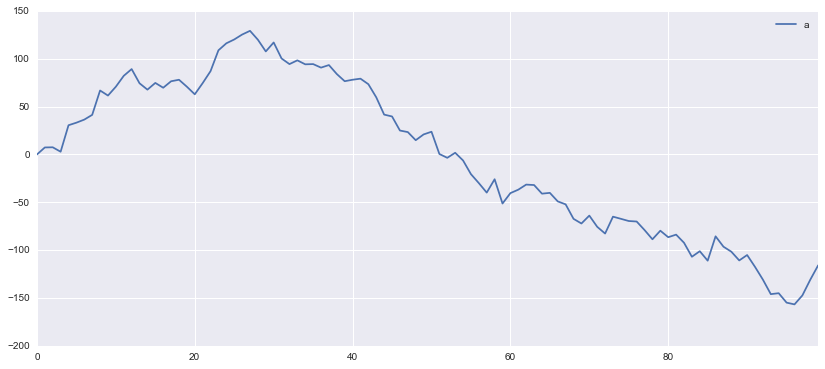

In [166]:
sigma_h = 10.0
h = np.random.normal(0, sigma_h, 110)
h[0] = 0.0
a = np.cumsum(h)

df = pd.DataFrame(a[0:100], columns=['a'])
_=df.plot(figsize=(14,6))

Now we introduce a second time series that's just the original series, plus some noise:

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


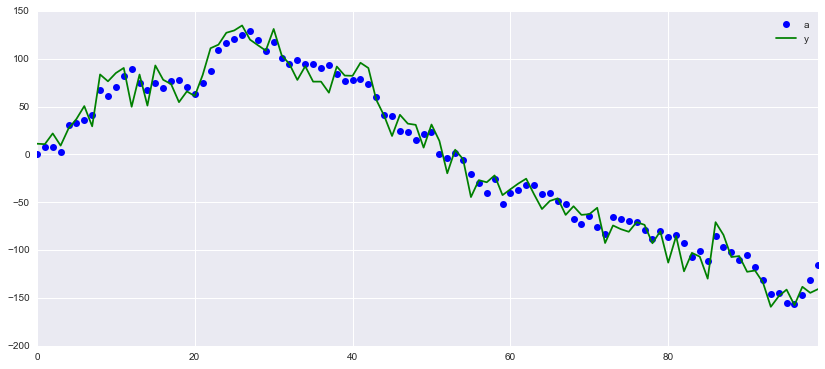

In [167]:
sigma_e = 15.
e = np.random.normal(0, sigma_e, 110)
df['y'] = a[0:100] + e[0:100]
_=df.plot(figsize=(14,6), style=['bo', 'g-',])

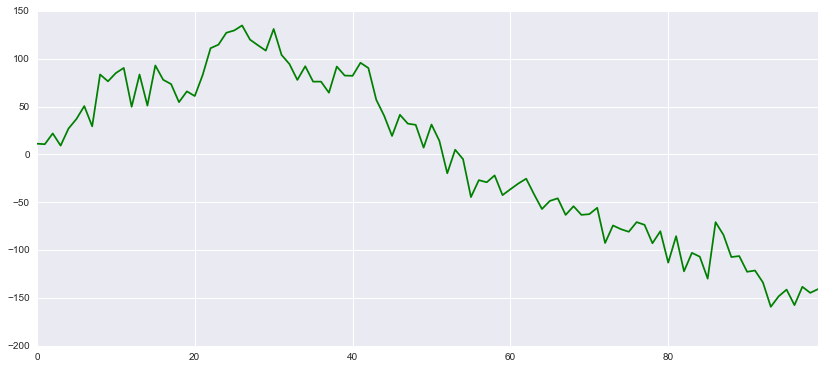

In [168]:
_=df.y.plot(figsize=(14,6), style=['g-',])

If we can only observe _y_, what can we say about &alpha;?

<img src='data/pydata_chicago/KalmanEstimation.png'>

- Filtering is estimating the state for the latest y_t (ie, removing the noise).
  - Ie, removing the noise
  - Nowcasting
- Smoothing/interpolation is estimating former states
- Prediction/forecasting is estimating the next state

## The Kalman Filter Recursion for this Model

$$
\begin{align}
v_t & = y_t - a_t &  F_t  & = P_t + \sigma^2_\epsilon \\
a_{t|t} & = a_t + K_t v_t & P_{t|t} & = P_t(1-K_t) \\
a_{t+1} & = a_t + K_t v_t & P_{t+1} & = P_t(1-K_t) + \sigma^2_\eta\\
\end{align}
$$


## What We Know at Y<sub>t-1</sub>

- This conditional distribution:

$$
\begin{align}
p(\alpha_t | Y_{t-1}) & = N(a_t, P_t) \\
\end{align}
$$

- a<sub>t</sub> and P<sub>t</sub>
- The distribution of the forecast error, or _innovation_, v<sub>t</sub>.

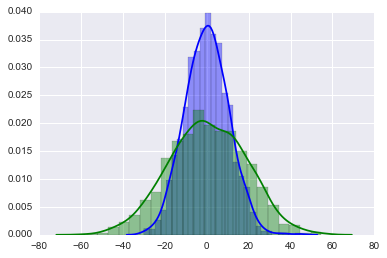

In [169]:
y_next = []
v_next = []
a_dist = np.random.normal(0, sigma_h, 1000)
a_1 = 0.
for i in range(1000):
    a_next = a_1 + np.random.normal(0, sigma_h)
    y_next.append(a_next + np.random.normal(0, sigma_e))
_=sns.distplot(a_dist, color='b', label='alpha')
_=sns.distplot(y_next, color='g', label='vt')

## What We Know at Y<sub>t</sub>

 - The latest observation, y<sub>t</sub>
 - v<sub>t</sub> = y<sub>t</sub> - a<sub>t</sub>
 
 
 ... also we know the relationship between &alpha;<sub>t</sub> and v<sub>t</sub>

## Regression Lemma

$$
\begin{align}
E(a|b) & = \mu_a + \frac{\sigma_{ab}}{\sigma_b^2}(b-\mu_b) &  Var(a|b) & = \sigma^2 - \frac{\sigma^2_{ab}}{\sigma_b^2}(b-\mu_b) \\
\end{align}
$$




$$
\sigma_{\alpha_t v_t} = Cov(\alpha_t,v_t|Y_{t}) = E[(\alpha_t - a_t)(v_t - 0)] = E[(\alpha_t - a_t)(\alpha_t + \epsilon - a_t)] = P_t
$$

$$
\begin{align}
E(\alpha_t|v_t) & = a_t + \frac{P_t}{P_t + \sigma^2_\epsilon}(y_t-a_t) &  Var(\alpha_t|v_t) & = \frac{P_t}{P_t+\sigma^2_\epsilon} \\
\end{align}
$$

This ratio:
$$
K = \frac{P_t}{P_t + \sigma^2_\epsilon}
$$

is called the _Kalman gain_

## Filtering


$$
\begin{align}
a_{t|t} & = a_t + K_t v_t & P_{t|t} & = P_t(1-K_t) \\
\end{align}
$$

$$
\begin{align}
p(\alpha_t | Y_t) & = N(a_{t|t}, P_{t|t}) \\
\end{align}
$$


$$
\begin{align}
Y_t & = \{y_1, y_2, \dots , y_t\} \\
a_{t|t} & = E(\alpha_t|Y_t) \\
P_{t|t} & = Var(\alpha_t|Y_t) \\
\end{align}
$$


## Forecasting

$$
\begin{align}
a_{t+1} & = a_t + K_t v_t & P_{t+1} & = P_t(1-K_t) + \sigma^2_\eta\\
\end{align}
$$

$$
\begin{align}
p(\alpha_{t+1} | Y_t) & = N(a_{t+1}, P_{t+1}) \\
\end{align}
$$

$$
\begin{align}
Y_t & = \{y_1, y_2, \dots , y_t\} \\
a_{t+1} & = E(\alpha_{t+1}|Y_t) \\
P_{t+1} & = Var(\alpha_{t+1}|Y_t) \\
\end{align}
$$


## State Space Model for Our Example


### State Equation

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(0, \sigma^2_{\eta}) \\
\end{align}
$$

### Observation (or Measurement) Equation

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


## State Space Models


### State Equation

$$
\begin{align}
\alpha_{t+1} & = T_t\alpha_{t} + R_t\eta_t  & \eta_t \sim N(0, Q_t) \\
\end{align}
$$

### Observation Equation

$$
\begin{align}
y_t & = Z_t\alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, H_t) \\
\end{align}
$$


- _T_ is transition matrix
- _Q_ is state covariance
- _Z_ is design matrix
- _H_ is observation covariance
- _R_ is selection matrix


<img src='./data/pydata_chicago/StateSpaceClass.png'>

In [170]:
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

kf = KalmanFilter(1,1)

kf.obs_cov = np.array([sigma_e])
kf.state_cov = np.array([sigma_h])
kf.design = np.array([1.0])
kf.transition = np.array([1.0])
kf.selection = np.array([1.0])

ys, ah = kf.simulate(100)

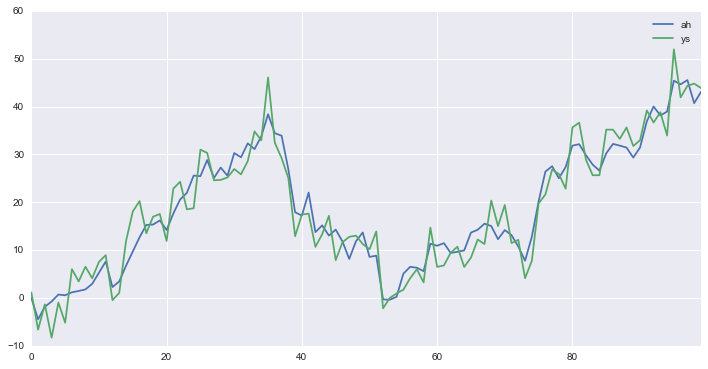

In [171]:
pd.DataFrame({'ys': ys.flatten(), 'ah': ah.flatten()}).plot(figsize=(12,6))

## Filtering

In [172]:
# Initialize known state
kf.initialize_known(np.array([0.0]), np.array([[sigma_h]]))
# Bind data
y = a + e
kf.bind(y.copy())
r = kf.filter()

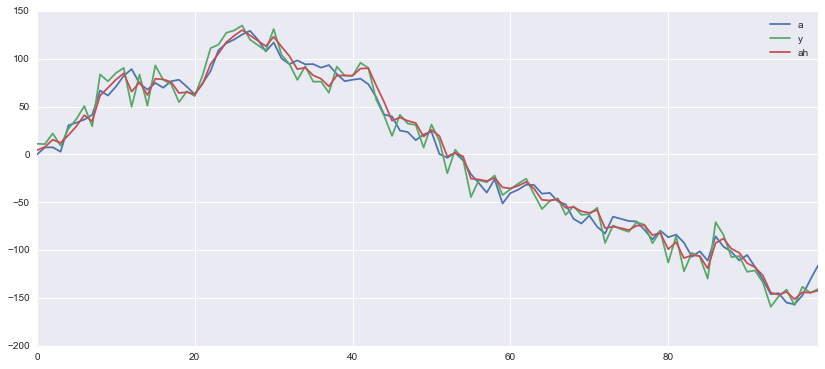

In [173]:
df['ah'] = r.predicted_state[0][1:101]
df.plot(figsize=(14,6))

## Forecasting

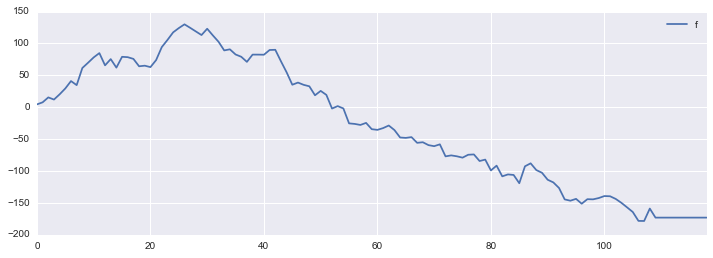

In [193]:
p = r.predict(90, 120, dynamic=20)
#pd.DataFrame({'y':y[:-1], 'f':p.results.forecasts[0][1:]}).plot(figsize=(12,4))
pd.DataFrame({'f':p.results.forecasts[0][1:]}).plot(figsize=(12,4))

## Other State Space Models: AR(p)

$$
   y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t
$$

$$
\begin{align}
   y_t & = \begin{bmatrix} 1 & 0 \end{bmatrix} \alpha_t \\
   \alpha_t & = \begin{bmatrix}
      \phi_1 & \phi_2 \\
           1 &      0
   \end{bmatrix} \alpha_{t-1} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta_t
\end{align}
$$




Where

$$
   Z_t \equiv Z = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$

and

$$
\begin{align}
   T_t \equiv T & = \begin{bmatrix}
      \phi_1 & \phi_2 \\
           1 &      0
   \end{bmatrix} \\
   R_t \equiv R & = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
   \eta_t & \sim N(0, \sigma^2)
\end{align}
$$

## SARIMAX